In [1]:
!python3 data_processing.py

In [2]:
import os
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
"""
Data Folder for YOLOv5 tests
"""
data_folder = "./data-yolo"


### Get Data

In [4]:
def filter_images_with_labels(image_files, data_folder):
    """Filters image files to include only those with corresponding label files."""
    valid_images = []
    for img_file in image_files:
        label_file = img_file.replace(".jpg", ".txt")
        if os.path.exists(os.path.join(data_folder, label_file)):
            valid_images.append((img_file, label_file))
    return valid_images

image_files = [f for f in os.listdir(data_folder) if f.endswith(".jpg")]
filtered_images = filter_images_with_labels(image_files, data_folder)

### Data Analysis

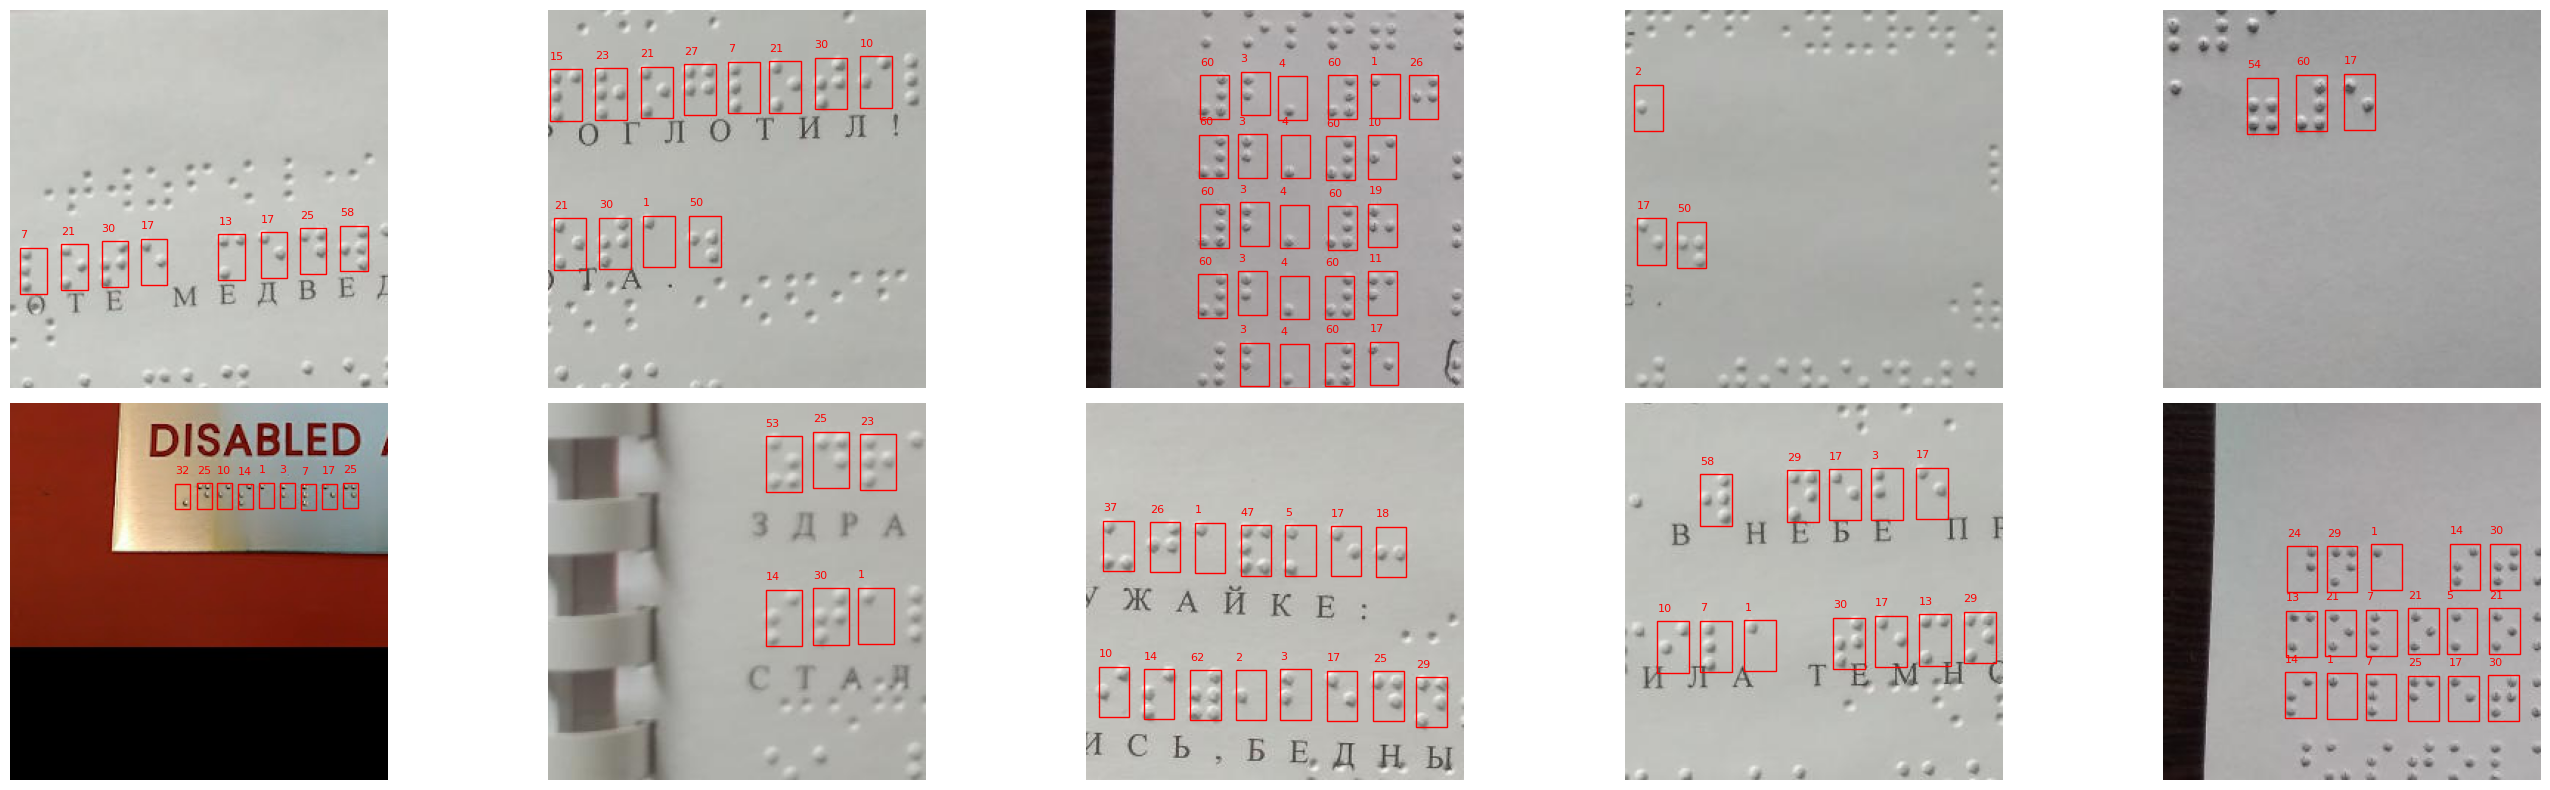

In [5]:
random_images = random.sample(filtered_images, min(10, len(filtered_images)))

def plot_annotated_images(image_files):
    fig, axs = plt.subplots(2, 5, figsize=(28, 8))
    axs = axs.flatten()

    for idx, (img_file, lbl_file) in enumerate(image_files):
        img_path = os.path.join(data_folder, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        height, width, _ = img.shape
        
        with open(os.path.join(data_folder, lbl_file), "r") as f:
            boxes = f.readlines()
        
        axs[idx].imshow(img)
        for box in boxes:
            class_id, x_center, y_center, box_width, box_height = map(float, box.strip().split())
            x_center *= width
            y_center *= height
            box_width *= width
            box_height *= height
            x_min = x_center - box_width / 2
            y_min = y_center - box_height / 2
            
            axs[idx].add_patch(plt.Rectangle((x_min, y_min), box_width, box_height, edgecolor='red', facecolor='none'))
            axs[idx].text(x_min, y_min - 5, f"{int(class_id) + 1}", color='red', fontsize=8, verticalalignment='bottom')

        axs[idx].axis("off")

    for j in range(idx + 1, 10):
        axs[j].axis("off")

    plt.tight_layout()
    plt.show()

plot_annotated_images(random_images)


In [6]:
freq_label = {}

for idx, (_, lbl_file) in enumerate(filtered_images):
    with open(os.path.join(data_folder, lbl_file), 'r') as label:
        labels = label.readlines()
        
    labels = [int(l.strip().split()[0]) for l in labels]
    for label in labels:
        if label in freq_label:
            freq_label[label] += 1
        else:
            freq_label[label] = 1

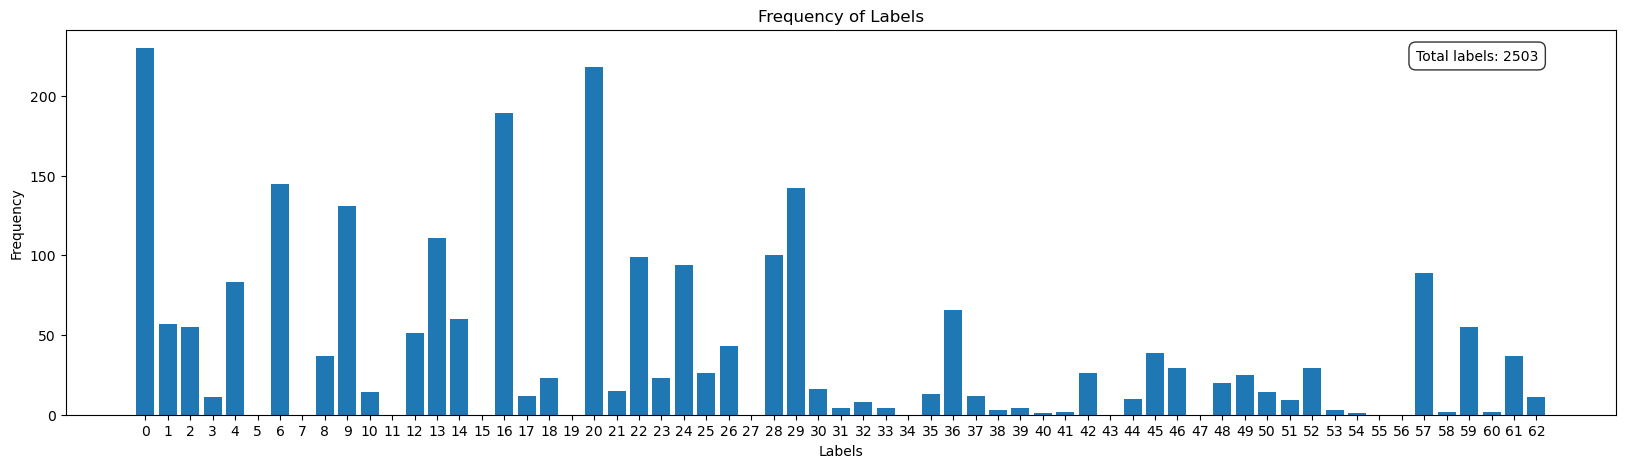

In [7]:
from typing import Dict

def plot_freq_map(freq_map:Dict, x_label:str='Labels', y_label:str='Frequency', title:str='Frequency of Labels'):
    keys = sorted(freq_map.keys())
    values = [freq_map[key] for key in keys]
    total = sum(values)
    
    plt.figure(figsize=(20, 5))
    plt.bar(keys, values)
    plt.xticks(range(min(keys), max(keys) + 1))
    plt.gca().text(0.95, 0.95, f'Total labels: {total}', ha='right', va='top', transform=plt.gca().transAxes,
                   bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.5'))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    
    plt.show()

plot_freq_map(freq_map=freq_label)

### YOLOv5 Only

<img src="yolov5-model-structure.avif" alt="YOLOv5 Model Structure" width="50%">

train, test, validation split: 60, 20, 20

In [8]:
from ultralytics import YOLO
import shutil
from sklearn.model_selection import train_test_split

NUM_EPOCHS_YOLO = 80
BATCH_SIZE_YOLO = 18

yolo_data_folder = './yolo-data'
os.makedirs(yolo_data_folder, exist_ok=True)

model = YOLO('yolov5s.pt')

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



In [9]:
train_images, temp_images = train_test_split(filtered_images, test_size=0.4, random_state=42)
val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

os.makedirs(os.path.join(yolo_data_folder, 'train', 'images'), exist_ok=True)
os.makedirs(os.path.join(yolo_data_folder, 'train', 'labels'), exist_ok=True)
os.makedirs(os.path.join(yolo_data_folder, 'val', 'images'), exist_ok=True)
os.makedirs(os.path.join(yolo_data_folder, 'val', 'labels'), exist_ok=True)
os.makedirs(os.path.join(yolo_data_folder, 'test', 'images'), exist_ok=True)
os.makedirs(os.path.join(yolo_data_folder, 'test', 'labels'), exist_ok=True)

for img_file, label_file in train_images:
    shutil.copy(os.path.join(data_folder, img_file), os.path.join(yolo_data_folder, 'train', 'images'))
    shutil.copy(os.path.join(data_folder, label_file), os.path.join(yolo_data_folder, 'train', 'labels'))

for img_file, label_file in val_images:
    shutil.copy(os.path.join(data_folder, img_file), os.path.join(yolo_data_folder, 'val', 'images'))
    shutil.copy(os.path.join(data_folder, label_file), os.path.join(yolo_data_folder, 'val', 'labels'))

for img_file, label_file in test_images:
    shutil.copy(os.path.join(data_folder, img_file), os.path.join(yolo_data_folder, 'test', 'images'))
    shutil.copy(os.path.join(data_folder, label_file), os.path.join(yolo_data_folder, 'test', 'labels'))

In [10]:
if os.path.exists('./runs'):
    shutil.rmtree('./runs')
history = model.train(data='yolo.yaml', epochs=NUM_EPOCHS_YOLO, batch=BATCH_SIZE_YOLO)

Ultralytics 8.3.28 🚀 Python-3.12.2 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5931MiB)
engine/trainer: task=detect, mode=train, model=yolov5s.pt, data=yolo.yaml, epochs=80, time=None, patience=100, batch=18, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

train: Scanning /home/zeenx1popos/Documents/codes/fyb/yolo-data/train/labels.cache... 172 images, 0 backgrounds, 0 corrupt: 100%|██████████| 172/172 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/home/zeenx1popos/.conda/envs/fybp/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /home/zeenx1popos/Documents/codes/fyb/yolo-data/val/labels.cache... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000149, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005625000000000001), 75 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80       4.6G      3.046      6.004       2.18        126        640: 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         66        940   0.000111    0.00208    6.4e-05   3.07e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80      4.88G      2.615       5.53      1.875        106        640: 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]

                   all         66        940    0.00253     0.0356    0.00199    0.00103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80      4.59G       2.05      4.969       1.53        132        640: 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]

                   all         66        940    0.00451      0.079    0.00596    0.00347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80      4.57G      1.871      4.497      1.405        172        640: 100%|██████████| 10/10 [00:02<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all         66        940     0.0233      0.156     0.0235     0.0138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80      4.89G      1.592      3.887      1.249        173        640: 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         66        940       0.59     0.0891     0.0283     0.0188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80      4.76G      1.428      3.473      1.154         95        640: 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         66        940       0.57     0.0906     0.0411     0.0294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80      4.77G        1.3      3.142        1.1        152        640: 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

                   all         66        940      0.542      0.159     0.0898     0.0672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80      5.16G       1.27      2.931      1.096        204        640: 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]

                   all         66        940      0.525      0.202      0.125     0.0946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80      4.77G      1.213      2.704      1.061        163        640: 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         66        940      0.512      0.233      0.145      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80      4.71G      1.142      2.458      1.048        108        640: 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         66        940      0.591      0.212      0.183      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80      4.81G       1.16      2.357      1.046        100        640: 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         66        940      0.575        0.3      0.261      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80      4.78G      1.112      2.145      1.039        182        640: 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         66        940      0.544      0.328       0.31      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80      4.75G       1.11      2.095       1.01        250        640: 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

                   all         66        940      0.661       0.31      0.331      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80      4.82G      1.018      1.873     0.9872        194        640: 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

                   all         66        940      0.673      0.347      0.344      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80      4.71G      1.034      1.833      1.006        146        640: 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]

                   all         66        940      0.671      0.366      0.394      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80      4.79G      1.037      1.773      1.024        104        640: 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         66        940      0.671      0.378      0.389      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80      4.78G      1.068      1.808     0.9888        200        640: 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]

                   all         66        940      0.745       0.36      0.468      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80      4.78G      1.081      1.704      1.013         99        640: 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         66        940      0.608      0.473      0.466      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80      4.58G      1.025      1.629      0.988        135        640: 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]

                   all         66        940      0.615       0.49      0.488      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80       4.8G      1.036       1.58     0.9942        198        640: 100%|██████████| 10/10 [00:02<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

                   all         66        940      0.648      0.484      0.505      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80      4.71G     0.9963      1.535     0.9975         80        640: 100%|██████████| 10/10 [00:02<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         66        940      0.721      0.488       0.53      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80      4.76G     0.9872      1.516     0.9896        167        640: 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

                   all         66        940      0.711      0.491      0.548       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80      4.69G     0.9868      1.489     0.9842        141        640: 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         66        940       0.71      0.518      0.565      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80      4.74G     0.9536      1.412     0.9554        272        640: 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         66        940      0.743      0.511      0.575      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80      4.73G     0.9581      1.418     0.9637        148        640: 100%|██████████| 10/10 [00:02<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]

                   all         66        940      0.735       0.52      0.602      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80      4.74G     0.9528      1.316     0.9601        137        640: 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         66        940      0.705      0.514      0.598      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80      4.71G     0.9677      1.342     0.9658        153        640: 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]

                   all         66        940      0.772      0.519      0.596      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80       4.8G     0.9214      1.319     0.9573        223        640: 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         66        940      0.799      0.535      0.622      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80      4.79G     0.9101      1.223     0.9434        263        640: 100%|██████████| 10/10 [00:02<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

                   all         66        940      0.736      0.553       0.65      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80      5.01G     0.9266      1.274     0.9671        156        640: 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         66        940      0.735      0.553      0.632      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80      5.04G      0.947      1.269      0.978        183        640: 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]

                   all         66        940      0.733      0.541      0.651      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80      4.75G     0.9001      1.198     0.9515        177        640: 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         66        940      0.817      0.527      0.661      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80      4.61G     0.9073      1.231     0.9448         99        640: 100%|██████████| 10/10 [00:02<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         66        940      0.829       0.54      0.671      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80      4.74G     0.9002      1.168     0.9564        104        640: 100%|██████████| 10/10 [00:02<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         66        940      0.669      0.632       0.68      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80      4.76G     0.8964      1.132     0.9532        218        640: 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

                   all         66        940      0.771      0.578      0.688      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80      5.06G     0.9334      1.197     0.9456        105        640: 100%|██████████| 10/10 [00:02<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

                   all         66        940      0.756      0.562      0.686      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/80      4.78G     0.8885      1.082     0.9525        194        640: 100%|██████████| 10/10 [00:02<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         66        940      0.658      0.622      0.676       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/80      4.76G     0.9284      1.173     0.9744        209        640: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]

                   all         66        940      0.723      0.635      0.702      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/80      4.79G     0.9063      1.149     0.9409        140        640: 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

                   all         66        940      0.735      0.639      0.711      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/80      4.73G     0.8851      1.096     0.9629        102        640: 100%|██████████| 10/10 [00:02<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

                   all         66        940       0.77      0.617      0.695      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/80      4.76G     0.8786      1.109      0.935        317        640: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         66        940      0.803      0.597      0.695      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/80      4.77G     0.8736      1.066     0.9393        200        640: 100%|██████████| 10/10 [00:02<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

                   all         66        940      0.748      0.649      0.706      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/80      4.69G     0.9014      1.115     0.9238        227        640: 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         66        940      0.774      0.642      0.724      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/80      4.79G     0.8796      1.043     0.9431        100        640: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         66        940      0.777      0.628      0.728      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/80      4.77G     0.9145      1.081     0.9435        152        640: 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

                   all         66        940      0.789      0.637      0.726      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/80      4.76G     0.8626      1.002      0.937         95        640: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         66        940      0.814      0.638      0.715      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80      4.75G     0.8866      1.062     0.9382        210        640: 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         66        940      0.766      0.648      0.733      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/80      4.77G     0.8957      1.095     0.9483         67        640: 100%|██████████| 10/10 [00:02<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]

                   all         66        940      0.768      0.646      0.747        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/80      4.74G     0.8388       1.02     0.9229        253        640: 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

                   all         66        940      0.841      0.653      0.757      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/80      4.64G      0.842     0.9956     0.9274        173        640: 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         66        940      0.837      0.671      0.765      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80      4.81G     0.8489     0.9713     0.9252        198        640: 100%|██████████| 10/10 [00:02<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

                   all         66        940      0.855      0.667      0.765      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80      4.76G     0.8782     0.9624     0.9429        132        640: 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         66        940      0.857      0.668      0.755      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/80      4.65G     0.8266     0.9499     0.9312        114        640: 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]

                   all         66        940      0.782      0.708      0.762      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/80      4.78G     0.8461     0.9452     0.9263        166        640: 100%|██████████| 10/10 [00:02<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         66        940      0.814      0.705      0.759      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80      4.77G     0.8621       1.01     0.9249         96        640: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]

                   all         66        940       0.82      0.692      0.758      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80      4.81G      0.898      1.005     0.9381        133        640: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

                   all         66        940      0.829      0.669      0.749      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/80      4.77G      0.879     0.9672     0.9487        165        640: 100%|██████████| 10/10 [00:02<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

                   all         66        940      0.799       0.68      0.753      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/80      4.97G      0.888      1.045     0.9341        304        640: 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         66        940      0.839      0.671      0.766      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/80       4.8G     0.8436     0.9574     0.9186        160        640: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]

                   all         66        940      0.823      0.678      0.774      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/80      4.76G     0.8259     0.9362      0.936        146        640: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]

                   all         66        940      0.853      0.664      0.771       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/80      4.75G     0.8545     0.9845     0.9241        157        640: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         66        940      0.784      0.709      0.769      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/80      4.78G     0.8114      0.905     0.9058        188        640: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]

                   all         66        940      0.784      0.715      0.776      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/80       4.8G     0.8211     0.9078     0.9378        199        640: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

                   all         66        940       0.79      0.719      0.785      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/80      4.72G      0.849     0.9142     0.9219        174        640: 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

                   all         66        940      0.842      0.681      0.783      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/80      4.78G     0.8397     0.9304     0.9151        287        640: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         66        940      0.823      0.698      0.781      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/80      4.82G      0.854     0.9254     0.9186        181        640: 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         66        940      0.748      0.746       0.79       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/80      4.72G     0.8493     0.9467     0.9175        239        640: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

                   all         66        940      0.736      0.748      0.788      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/80      4.78G     0.8271     0.9273     0.9148        176        640: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         66        940      0.819      0.695      0.776      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/80      4.76G     0.7798     0.8558     0.9063         91        640: 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

                   all         66        940      0.829      0.695      0.781      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/80      4.71G     0.8085     0.8782     0.9114        150        640: 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         66        940      0.847      0.687      0.782      0.632


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/80      4.67G     0.8004     0.8529     0.9165         80        640: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

                   all         66        940       0.76      0.758      0.799      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/80      4.71G     0.8045     0.8062     0.9121        105        640: 100%|██████████| 10/10 [00:02<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]

                   all         66        940      0.788      0.741      0.798      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/80       4.8G     0.8218      0.853     0.9214        100        640: 100%|██████████| 10/10 [00:02<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]

                   all         66        940      0.791      0.737      0.797      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/80      4.69G     0.8217      0.882     0.9186         91        640: 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]

                   all         66        940       0.77      0.744      0.795      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/80      4.72G     0.7933     0.8065     0.9127        141        640: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         66        940      0.758      0.757      0.793       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      76/80      4.71G     0.7936     0.7898     0.9114        102        640: 100%|██████████| 10/10 [00:02<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         66        940      0.891      0.642      0.798      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      77/80      4.67G     0.7704     0.8024     0.9109        162        640: 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]

                   all         66        940      0.882      0.647      0.799      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      78/80      4.79G     0.8059     0.8359     0.9292        108        640: 100%|██████████| 10/10 [00:02<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         66        940       0.75      0.747      0.798      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      79/80      4.77G     0.7936     0.8355     0.9117         86        640: 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]

                   all         66        940      0.735      0.733      0.798      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      80/80       4.8G     0.8067     0.8228     0.9194         85        640: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         66        940      0.733      0.734      0.798      0.638



80 epochs completed in 0.089 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.28 🚀 Python-3.12.2 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5931MiB)
YOLOv5s summary (fused): 193 layers, 9,135,917 parameters, 0 gradients, 24.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]


                   all         66        940       0.76      0.757      0.799      0.644
                     1         41         99      0.821      0.818      0.844      0.657
                     2         16         23      0.768      0.861      0.902      0.688
                     3         16         19      0.699      0.684       0.76       0.58
                     5         22         27      0.701      0.852      0.853      0.707
                     7         29         50      0.778       0.92      0.923      0.734
                     9         11         12      0.751      0.667      0.739       0.52
                    10         28         50      0.652       0.94      0.931      0.743
                    11          3          3      0.964      0.667       0.83      0.714
                    13         16         20      0.885      0.767      0.806      0.659
                    14         24         42      0.762      0.857      0.901      0.704
                    1

#### Training and Validation Loss

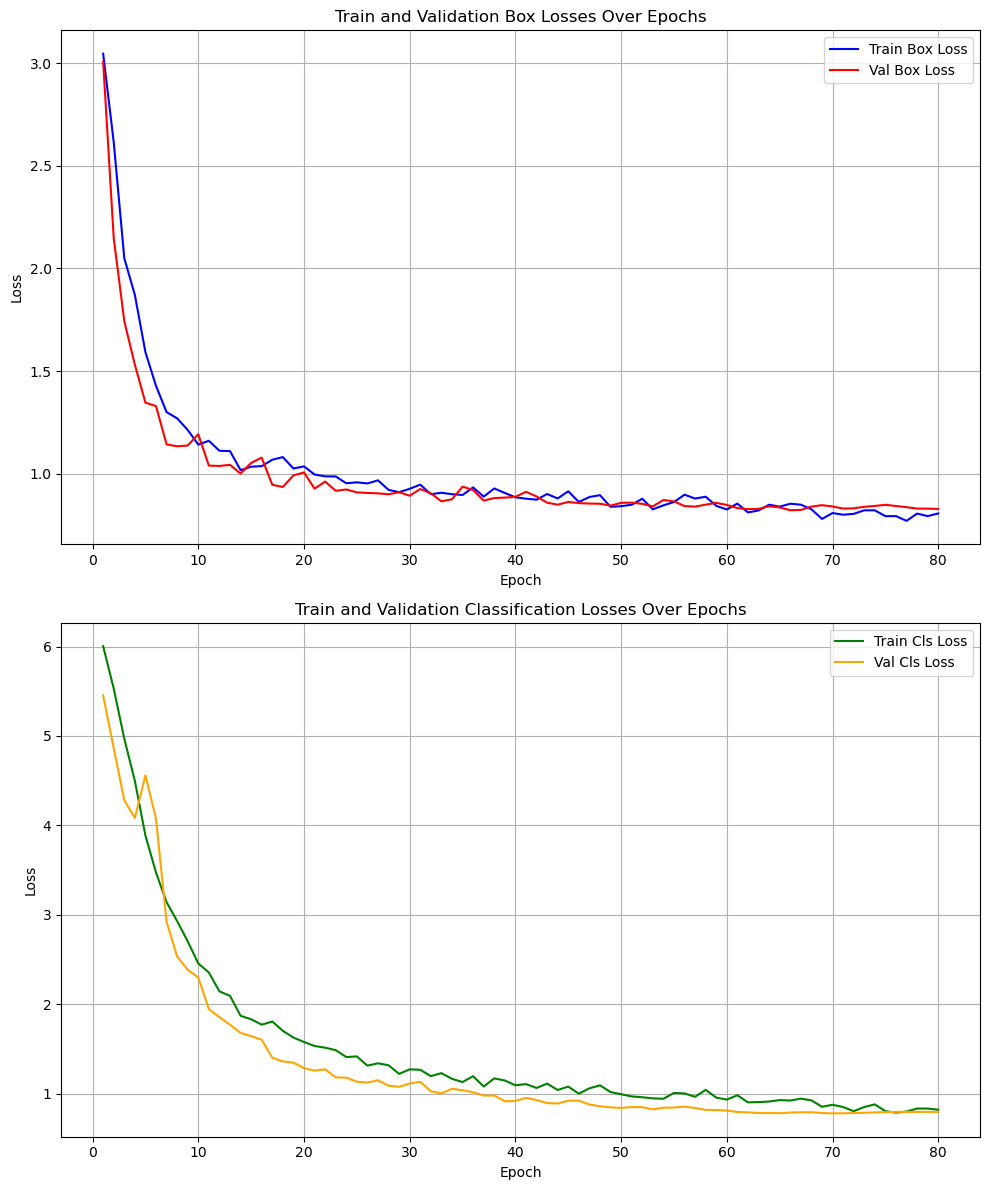

In [11]:
YOLO_RESULTS_FOLDER = './runs/detect/train'

import pandas as pd

df = pd.read_csv(os.path.join(YOLO_RESULTS_FOLDER, 'results.csv'))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

ax1.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', color='blue')
ax1.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Train and Validation Box Losses Over Epochs')
ax1.legend()
ax1.grid(True)

ax2.plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss', color='green')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss', color='orange')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Train and Validation Classification Losses Over Epochs')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()



In [12]:
test_images_path = os.path.join(yolo_data_folder, 'test', 'images')

model_weights = os.path.join(YOLO_RESULTS_FOLDER, 'weights/best.pt')
trained_model = YOLO(model_weights)



image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG_20190821_123648.labeled_512_0.jpg: 640x640 6 1s, 7 5s, 1 7, 1 21, 1 23, 1 26, 1 29, 2 30s, 1 37, 1 43, 2 50s, 1 53, 1 58, 7.0ms
Speed: 2.6ms preprocess, 7.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


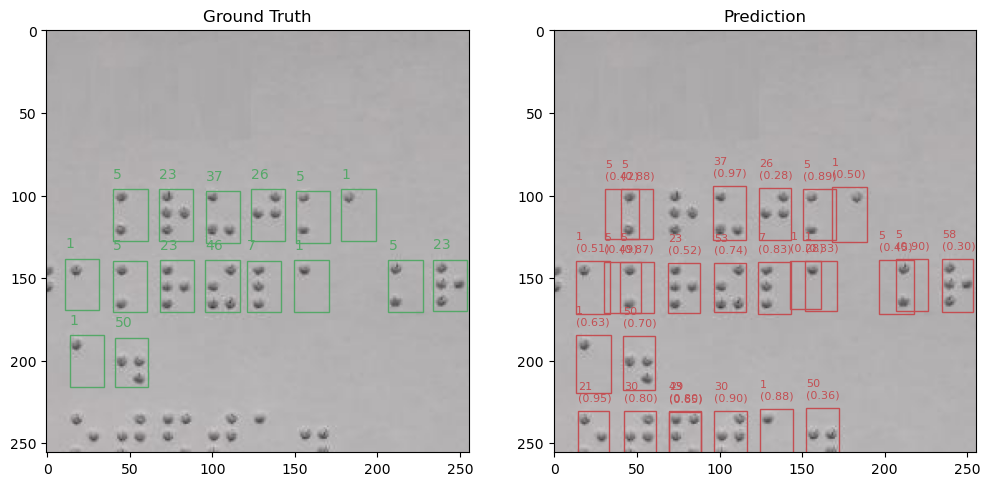


image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG_20190715_113013.labeled_0_0.jpg: 640x640 1 1, 1 23, 1 58, 6.4ms
Speed: 1.5ms preprocess, 6.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


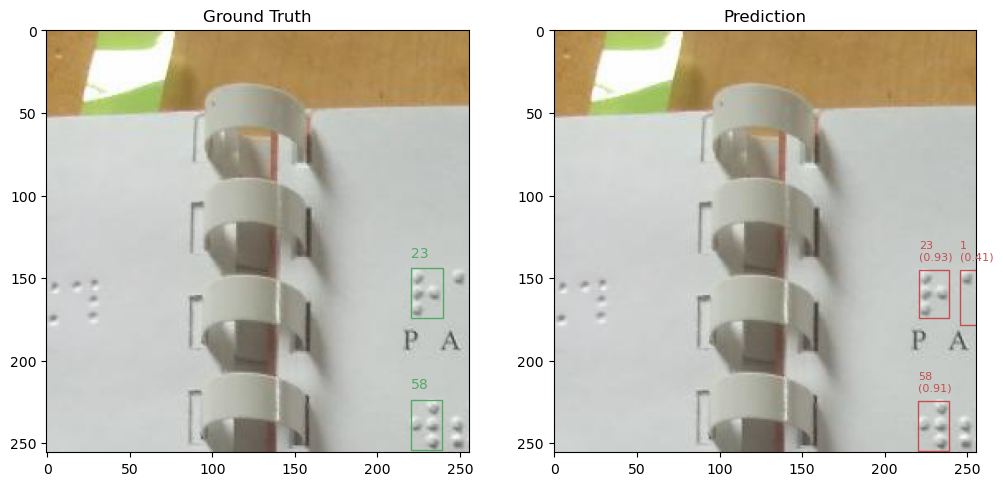


image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG_20190715_113010.labeled_0_768.jpg: 640x640 1 1, 1 10, 2 13s, 1 14, 2 17s, 1 21, 2 25s, 1 29, 1 30, 1 38, 2 46s, 1 52, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


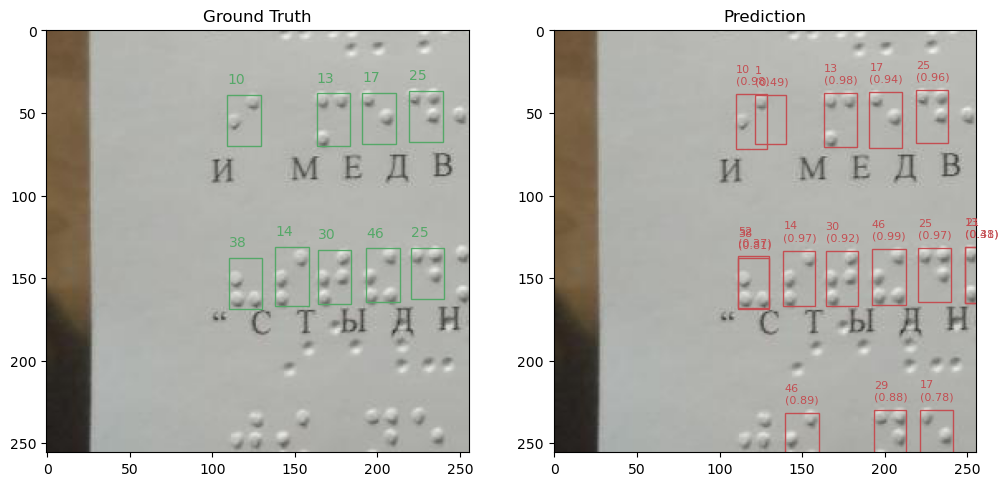


image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG_20190715_112947.labeled_256_0.jpg: 640x640 3 1s, 1 3, 1 5, 1 7, 1 10, 1 17, 1 21, 1 22, 2 23s, 1 26, 1 27, 1 37, 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


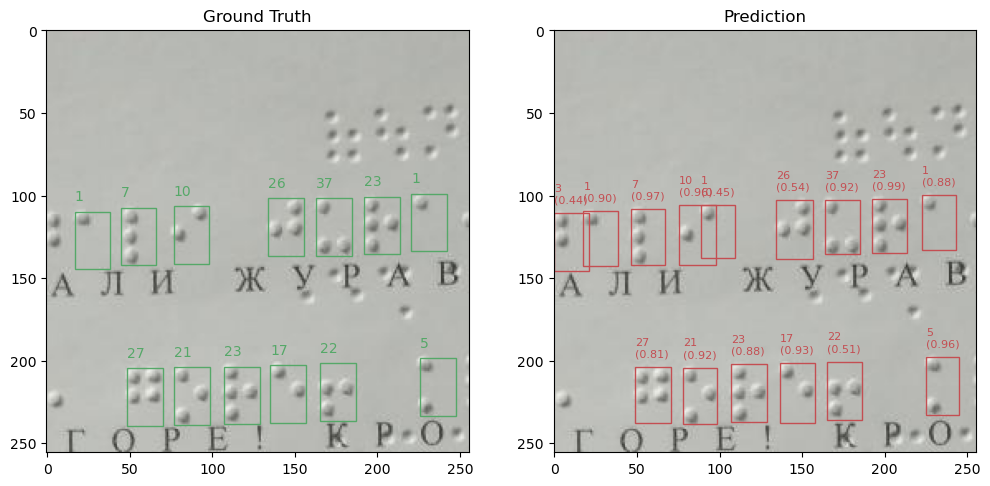


image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG_20190715_113023.labeled_0_512.jpg: 640x640 1 7, 2 10s, 2 17s, 2 21s, 1 26, 1 27, 1 29, 1 49, 1 58, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


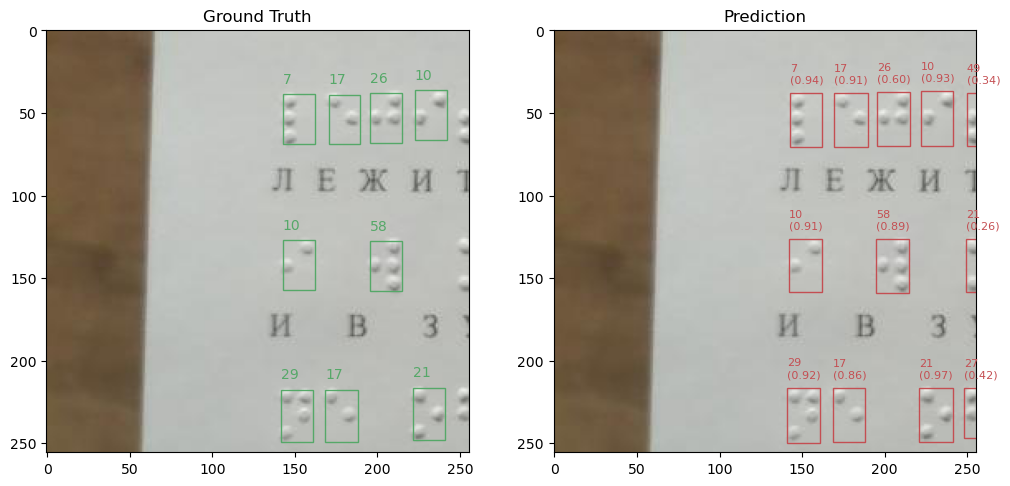

In [13]:
from random import choice

def plot_annotated_images_with_predictions(test_images, trained_model):
    img_file, lbl_file = choice(test_images)
    img_file = os.path.join(yolo_data_folder, 'test', 'images', img_file)
    lbl_file = os.path.join(yolo_data_folder, 'test', 'labels', lbl_file)
    
    img = cv2.imread(img_file)
    
    if img is None:
        print(f"Error: Could not load image {img_file}")
        return
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, _ = img.shape
    
    with open(lbl_file, "r") as f:
        ground_truth_boxes = f.readlines()
    
    results = trained_model(img_file)
    predictions = results[0].boxes.xywh.cpu().numpy()
    confidences = results[0].boxes.conf.cpu().numpy()
    class_ids = results[0].boxes.cls.cpu().numpy()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.imshow(img_rgb)
    ax1.set_title("Ground Truth")
    
    for gt_box in ground_truth_boxes:
        class_id, x_center, y_center, box_width, box_height = map(float, gt_box.strip().split())
        x_center *= width
        y_center *= height
        box_width *= width
        box_height *= height
        x_min = x_center - box_width / 2
        y_min = y_center - box_height / 2
        ax1.add_patch(plt.Rectangle((x_min, y_min), box_width, box_height, edgecolor='g', facecolor='none'))
        ax1.text(x_min, y_min - 5, f"{int(class_id) + 1}", color='g', fontsize=10, verticalalignment='bottom')
    
    ax2.imshow(img_rgb)
    ax2.set_title("Prediction")
    
    for pred_box, confidence, class_id in zip(predictions, confidences, class_ids):
        x_center, y_center, width_pred, height_pred = pred_box
        
        x_min = x_center - width_pred / 2
        y_min = y_center - height_pred / 2
        
        ax2.add_patch(plt.Rectangle((x_min, y_min), width_pred, height_pred, edgecolor='r', facecolor='none'))
        ax2.text(x_min, y_min - 5, f"{int(class_id) + 1}\n({confidence:.2f})", color='r', fontsize=8, verticalalignment='bottom')
    
    plt.show()

    
for _ in range(5):
    plot_annotated_images_with_predictions(test_images, trained_model)

In [14]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def iou_score(box_a, box_b):
    """Calculate Intersection over Union (IoU) between two bounding boxes."""
    x_min_a, y_min_a, width_a, height_a = box_a
    x_min_b, y_min_b, width_b, height_b = box_b

    x_max_a, y_max_a = x_min_a + width_a, y_min_a + height_a
    x_max_b, y_max_b = x_min_b + width_b, y_min_b + height_b

    inter_x_min = max(x_min_a, x_min_b)
    inter_y_min = max(y_min_a, y_min_b)
    inter_x_max = min(x_max_a, x_max_b)
    inter_y_max = min(y_max_a, y_max_b)

    inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)
    area_a = width_a * height_a
    area_b = width_b * height_b

    union_area = area_a + area_b - inter_area
    iou = inter_area / union_area if union_area > 0 else 0
    return iou

def evaluate_model(test_images, trained_model, iou_threshold=0.5):
    ious, y_true, y_pred = [], [], []

    for img_file, lbl_file in test_images:
        img_path = os.path.join(yolo_data_folder, 'test', 'images', img_file)
        lbl_path = os.path.join(yolo_data_folder, 'test', 'labels', lbl_file)
        
        img = cv2.imread(img_path)
        
        if img is None:
            print(f"Error: Could not load image {img_path}")
            return
        
        height, width, _ = img.shape
        
        with open(lbl_path, "r") as f:
            ground_truth_boxes = [list(map(float, line.strip().split())) for line in f.readlines()]
        
        results = trained_model(img_path)
        predictions = results[0].boxes.xywh.cpu().numpy()
        pred_classes = results[0].boxes.cls.cpu().numpy()
        
        for gt_class, x_center, y_center, box_width, box_height in ground_truth_boxes:
            x_center *= width
            y_center *= height
            box_width *= width
            box_height *= height
            gt_box = [(x_center - box_width / 2), (y_center - box_height / 2), box_width, box_height]
            max_iou, matched_pred_class = 0, -1
            
            for pred_box, pred_class in zip(predictions, pred_classes):
                x_center, y_center, width_pred, height_pred = pred_box
                
                x_min = x_center - width_pred / 2
                y_min = y_center - height_pred / 2
                
                pred_box = [x_min, y_min, width_pred, height_pred]
                
                iou = iou_score(gt_box, pred_box)
                if iou > max_iou:
                    max_iou = iou
                    matched_pred_class = int(pred_class)
            
            ious.append(max_iou)
            y_true.append(int(gt_class))
            y_pred.append(matched_pred_class if max_iou >= iou_threshold else -1)
    
    ious = np.array(ious)
    avg_iou = np.mean(ious)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    conf_matrix = confusion_matrix(y_true, y_pred)

    return {
        'avg_iou': avg_iou,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix
    }

metrics = evaluate_model(test_images, trained_model)



image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG-20210928-WA0005_0_0.jpg: 640x640 3 9s, 1 13, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 17.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG_20190822_182350.labeled_0_256.jpg: 640x640 3 1s, 1 3, 3 7s, 1 13, 2 14s, 2 15s, 1 19, 7 21s, 1 22, 1 23, 2 24s, 1 25, 1 26, 1 29, 1 33, 1 37, 1 43, 1 47, 1 49, 2 50s, 1 63, 6.6ms
Speed: 1.7ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG_20190715_112947.labeled_256_0.jpg: 640x640 3 1s, 1 3, 1 5, 1 7, 1 10, 1 17, 1 21, 1 22, 2 23s, 1 26, 1 27, 1 37, 7.0ms
Speed: 2.5ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG_20190715_113026.labeled_256_256.jpg: 640x640 1 1, 2 2s, 3 7s, 

#### Evaluation

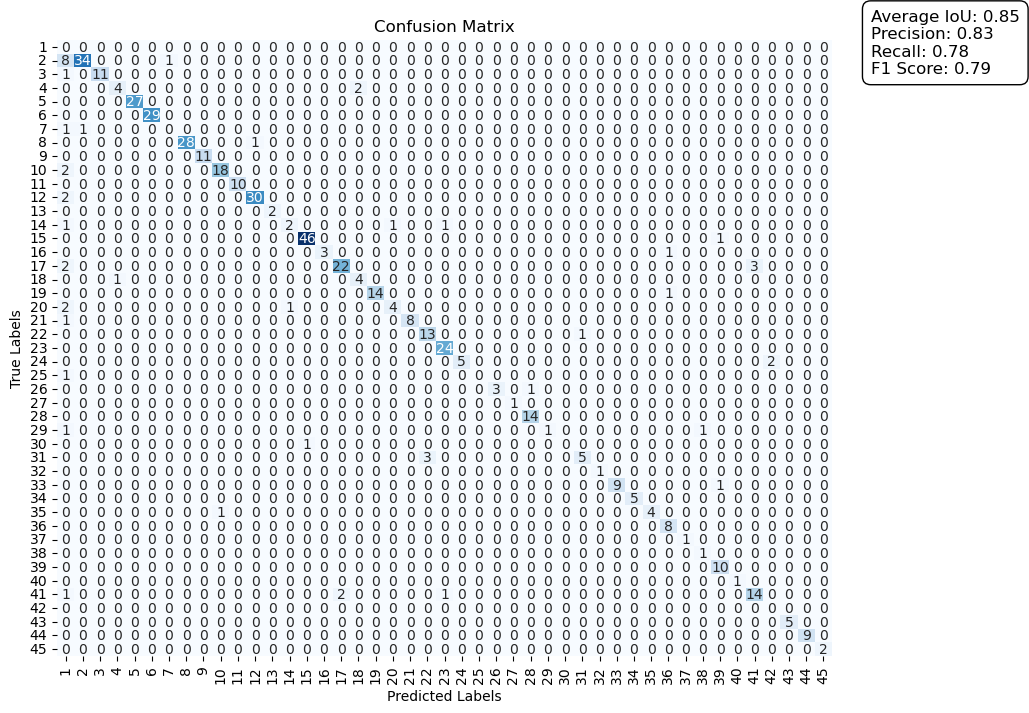

In [15]:
def plot_confusion_matrix(conf_matrix, class_names, metrics):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    
    metrics_text = (
        f"Average IoU: {metrics['avg_iou']:.2f}\n"
        f"Precision: {metrics['precision']:.2f}\n"
        f"Recall: {metrics['recall']:.2f}\n"
        f"F1 Score: {metrics['f1_score']:.2f}"
    )
    
    plt.gca().text(1.05, 1.05, metrics_text, transform=plt.gca().transAxes,
                   fontsize=12, verticalalignment='top',
                   bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    
    plt.show()

class_names = [f"{i + 1}" for i in range(len(metrics['confusion_matrix']))]
plot_confusion_matrix(metrics['confusion_matrix'], class_names, metrics)

### HOUGH TRANSFORM

In [16]:
def HoughTransform(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 3
    )
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    processed = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    
    contours, _ = cv2.findContours(processed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    output_image = np.full_like(gray, 50)
    
    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        
        # Set minimum and maximum size thresholds for Braille dots
        if 3 <= w <= 7 and 3 <= h <= 7:  # Size range for Braille dots
            area = cv2.contourArea(contour)
            if area < 50:
                confidence_intensity = int(255 - (area / 50) * 205)  # From 50 (low confidence) to 255 (high confidence)
                cv2.drawContours(output_image, [contour], -1, confidence_intensity, thickness=cv2.FILLED)

    return gray, blurred, thresh, processed, output_image

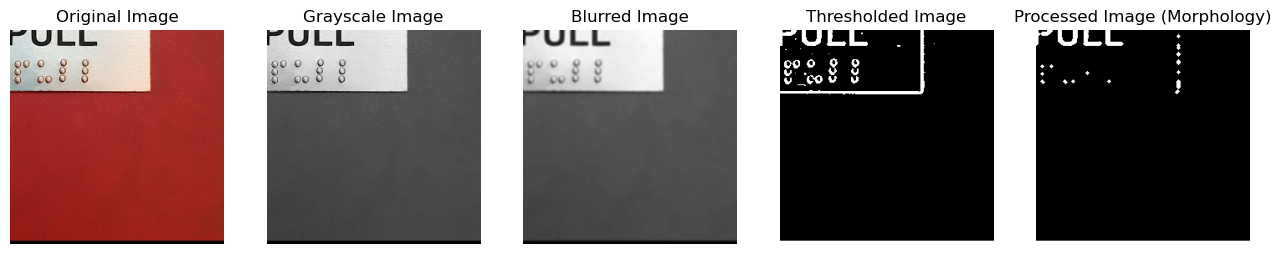

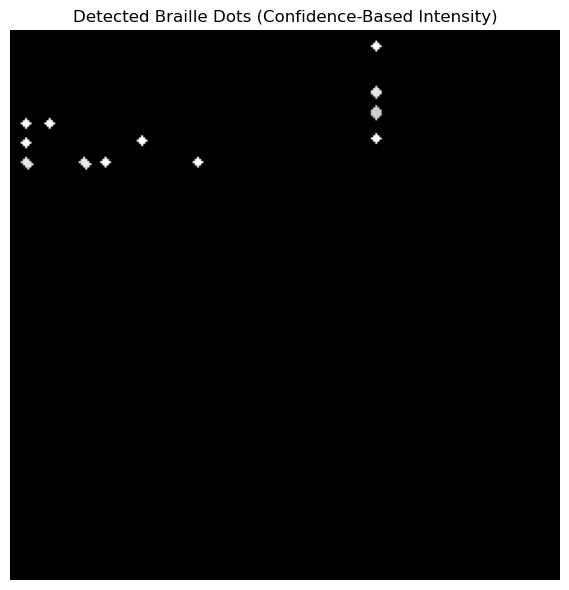

In [17]:
"""
TEST HOUGH TRANSFORM
"""
def test_hough_transform(image_path):
    test_image = cv2.imread(image_path)
    
    gray, blurred, thresh, processed, output_image = HoughTransform(test_image)
    
    plt.figure(figsize=(16, 8))
    
    plt.subplot(1, 5, 1)
    plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 5, 2)
    plt.imshow(gray, cmap='gray')
    plt.title("Grayscale Image")
    plt.axis('off')
    
    plt.subplot(1, 5, 3)
    plt.imshow(blurred, cmap='gray')
    plt.title("Blurred Image")
    plt.axis('off')
    
    plt.subplot(1, 5, 4)
    plt.imshow(thresh, cmap='gray')
    plt.title("Thresholded Image")
    plt.axis('off')
    
    plt.subplot(1, 5, 5)
    plt.imshow(processed, cmap='gray')
    plt.title("Processed Image (Morphology)")
    plt.axis('off')
    
    plt.figure(figsize=(6, 6))
    plt.imshow(output_image, cmap='gray')
    plt.title("Detected Braille Dots (Confidence-Based Intensity)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


"""
TEST
"""
test_hough_transform('./data-yolo/AF1QipOkgsneVSdYeba5vP16itZ79s642g-nPfsEr4h_256_256.jpg')

### TEXT SPOTTING MODEL

In [18]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
"""
Testing Models:
"""
def test_conv_block(model, skip=False, batch_size=16, imgsz=256):
    torch.cuda.empty_cache()
    model.to(device)
    layer1 = torch.randn(batch_size, 3, imgsz, imgsz).to(device)
    layer2 = None
    if skip:
        layer2 = torch.randn(batch_size, 3, imgsz, imgsz).to(device)
    output = model(layer1, layer2)
    print("Output shape:", output.shape)

class ConvolutionBlock(nn.Module):
    def __init__(self, in_channels=3, skip=False) -> None:
        super(ConvolutionBlock, self).__init__()
        self.skip = skip
        
        self.seq1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=in_channels,
                      kernel_size=1,
                      stride=1),
            nn.BatchNorm2d(in_channels),
            nn.SiLU(inplace=True)
        )
        
        self.seq2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=in_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(in_channels),
            nn.SiLU(inplace=True)
        )
        
        self.seq_g = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=in_channels,
                      kernel_size=1,
                      stride=1),
            nn.BatchNorm2d(in_channels),
            nn.SiLU(inplace=True)
        )
        
        self.silu = nn.SiLU(inplace=True)
        
    def forward(self, Xf, Xg=None):
        xf = self.seq1(Xf)
        xf = self.seq2(xf)
        if self.skip and Xg is not None:
            xg = self.seq_g(Xg)
            xf = torch.concat([xf, xg], dim=1)
        xf = self.silu(xf)
        return xf

"""
TEST
"""
test_conv_block(ConvolutionBlock()) # no skip
test_conv_block(ConvolutionBlock(skip=True), skip=True) # with skip

Output shape: torch.Size([16, 3, 256, 256])
Output shape: torch.Size([16, 6, 256, 256])


In [20]:
"""
Testing Models:
"""
def test_up_conv_block(model, ch_in=512, batch_size=16, imgsz=20):
    torch.cuda.empty_cache()
    model.to(device)
    image_tensor = torch.randn(batch_size, ch_in, imgsz, imgsz).to(device)
    output = model(image_tensor)
    print("Output shape:", output.shape)

class UpConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out, scale_factor=4):
        super().__init__()
        self.up = nn.Sequential(
                                nn.Upsample(scale_factor=scale_factor),
                                nn.Conv2d(ch_in, ch_out,
                                         kernel_size=3,stride=1,
                                         padding=1, bias=True),
                                nn.BatchNorm2d(ch_out),
                                nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = x = self.up(x)
        return x

"""
TEST
"""
test_up_conv_block(UpConvBlock(ch_in=512, ch_out=1024, scale_factor=2))

Output shape: torch.Size([16, 1024, 40, 40])


In [21]:
"""
Testing Models:
"""
def test_backbone(model, batch_size=16, imgsz=256):
    torch.cuda.empty_cache()
    model.to(device)
    image_tensor = torch.randn(batch_size, 3, imgsz, imgsz).to(device)
    output = model(image_tensor)
    print("Output shape:", output.shape)

class Backbone(nn.Module):
    """
    YOLO Backbone:
    
    output feature map: (batch_size, 3, 256, 256)
    """
    def __init__(self):
        super(Backbone, self).__init__()
        self.backbone = torch.hub.load("ultralytics/yolov5", "yolov5s").to(device)
        self.grid_size = 256
        
        self.conv1 = nn.Conv1d(4032, 512, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(512, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(128, 3, kernel_size=3, stride=1, padding=1)
        
        self.upsample1 = UpConvBlock(ch_in=3, ch_out=3)
        self.upsample2 = UpConvBlock(ch_in=3, ch_out=3)
        self.upsample3 = UpConvBlock(ch_in=3, ch_out=3, scale_factor=2)
        
        self._freeze_layers()
        
        
    def _freeze_layers(self):
        """
        Freezing the Backbone (except the last layer)
        """
        freeze = [f"model.{x}." for x in range(24)]
        for k, v in self.backbone.named_parameters():
            v.requires_grad = True
            if any(x in k for x in freeze):
                v.requires_grad = False
    
    def forward(self, x):
        """
        Creates an interface for the Backbone
        with output grid size: (batch_size, 3, self.grid_size, self.grid_size)
        """
        backbone_out = self.backbone.model.forward(x) # (batch_size, 4032, 85)
        
        l1 = self.conv1(backbone_out)  # (batch_size, 512, 85)
        l2 = self.conv2(l1)  # (batch_size, 128, 85)
        l3 = self.conv3(l2)  # (batch_size, 3, 85)
        
        l3 = l3.unsqueeze(-1)  # (batch_size, 3, 85, 1)
        
        l4 = self.upsample1(l3) # (batch_size, 3, 340, 4)
        l5 = self.upsample2(l4) # (batch_size, 3, 1360, 16)
        l6 = self.upsample3(l5) # (batch_size, 3, 2720, 32)
        
        out = torch.nn.functional.interpolate(l6, size=(self.grid_size, self.grid_size), mode='bilinear', align_corners=False)
        return out # (batch_size, 3, 256, 256)
    
"""
TEST
"""
test_backbone(Backbone())

Using cache found in /home/zeenx1popos/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-11-9 Python-3.12.2 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5931MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Output shape: torch.Size([16, 3, 256, 256])


In [22]:
"""
Testing Models:
"""
def test_retention(model, x1_channels=512, x2_channels=512, batch_size=16, imgsz=20):
    torch.cuda.empty_cache()
    model.to(device)
    layer1 = torch.randn(batch_size, x1_channels, imgsz, imgsz).to(device)
    layer2 = torch.randn(batch_size, x2_channels, imgsz, imgsz).to(device)
    output = model(layer1, layer2)
    print("Output shape:", output.shape)


class RetentionLayer(nn.Module):
    def __init__(self, x1_channels, x2_channels, mid_channels):
        super(RetentionLayer, self).__init__()
        self.seq1 = nn.Sequential(
            nn.Conv2d(
                in_channels=x1_channels,
                out_channels=mid_channels,
                kernel_size=1,
                stride=1,
                bias=True,
            ),
            nn.BatchNorm2d(mid_channels)
        )
        self.seq2 = nn.Sequential(
            nn.Conv2d(
                in_channels=x2_channels,
                out_channels=mid_channels,
                kernel_size=1,
                stride=1,
                bias=True,
            ),
            nn.BatchNorm2d(mid_channels)
        )
        self.relu = nn.ReLU(inplace=True)
        self.attention = nn.Sequential(
            nn.Conv2d(
                in_channels=mid_channels,
                out_channels=1,
                kernel_size=1,
                stride=1,
                bias=True,
            ),
            nn.BatchNorm2d(1),
            nn.Sigmoid(),
        )
        
    def forward(self, X1, X2):
        x1 = self.seq1(X1)
        x2 = self.seq2(X2)
        S = self.relu(x1 + x2)
        S = self.attention(S)
        return X1 * S

"""
TEST
"""
test_retention(RetentionLayer(512, 512, 256))

        

Output shape: torch.Size([16, 512, 20, 20])


In [23]:
"""
Testing Models:
"""
def test_HoughModule(model, batch_size=16, imgsz=512):
    torch.cuda.empty_cache()
    model.to(device)
    layer1 = torch.randn(batch_size, 3, imgsz, imgsz).to(device)
    output = model(layer1)
    print("Output shape:", output.shape)

class HoughModule(nn.Module):
    def __init__(self):
        super(HoughModule, self).__init__()
        self.seq1 = nn.Sequential(
            nn.Conv2d(in_channels=3,
                      out_channels=6,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(6),
            nn.SiLU(inplace=True),
            nn.Conv2d(in_channels=6,
                      out_channels=3,
                      kernel_size=1),
            nn.BatchNorm2d(3),
            nn.Sigmoid(),
        )
    
    def forward(self, image):
        image_np = image.permute(0, 2, 3, 1).cpu().numpy().astype(np.uint8)
        masks = []
        for img in image_np:
            _, _, _, _, mask = HoughTransform(img)
            masks.append(mask)
        mask_tensor = torch.tensor(np.stack(masks), dtype=torch.float32).unsqueeze(1).to(image.device)
        
        transformed_image = image * mask_tensor
        out = self.seq1(transformed_image)
        return out
    

"""
TEST
"""
test_HoughModule(HoughModule())

Output shape: torch.Size([16, 3, 512, 512])


### BBOX Prediction

In [24]:
"""
Testing Models:
"""
def test_BBoxPredictBlock(model, batch_size=16, imgsz=256):
    torch.cuda.empty_cache()
    model.to(device)
    layer1 = torch.randn(batch_size, 3, imgsz, imgsz).to(device)
    layer2 = torch.randn(batch_size, 3, imgsz, imgsz).to(device)
    output = model(layer1, layer2)
    print("Output shape:", output.shape)

class BBoxPredictBlock(nn.Module):
    def __init__(self) -> None:
        super(BBoxPredictBlock, self).__init__()
        
        self.combination = RetentionLayer(
            x1_channels=3,
            x2_channels=3,
            mid_channels=6
        )
        
        self.down_conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=64,
            kernel_size=6,
            stride=2,
            padding=2,
        )
        self.conv1 = ConvolutionBlock(in_channels=64, skip=True)
        
        self.down_conv2 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=6,
            stride=2,
            padding=2,
        )
        self.conv2 = ConvolutionBlock(in_channels=128, skip=True)
        
        self.down_conv3 = nn.Conv2d(
            in_channels=128,
            out_channels=256,
            kernel_size=6,
            stride=2,
            padding=2,
        )
        self.conv3 = ConvolutionBlock(in_channels=256, skip=True)
        
        self.down_conv4 = nn.Conv2d(
            in_channels=256,
            out_channels=512,
            kernel_size=6,
            stride=2,
            padding=2,
        )
        self.conv4 = ConvolutionBlock(in_channels=512, skip=True)
        
        self.predict_head = nn.Conv2d(in_channels=512,
                                      out_channels=9 * 3, # [class_probability x1 y1 x2 y2 x3 y3 x4 y4] * 3
                                      kernel_size=1,      # Every one of the 16 X 16 "block" outputs 3 cells with the OBB coords
                                      stride=1)
        
    def forward(self, x, img):
        """
        x, img: (batch_size, 3, 256, 256)
        """
        combined = self.combination(x, img)                               # (batch_size, 3, 256, 256)
        
        x1 = self.down_conv1(combined)                                    # (batch_size, 64, 128, 128)
        x1 = self.conv1(x1)                                               # (batch_size, 64, 128, 128)
        
        x2 = self.down_conv2(x1)                                          # (batch_size, 128, 64, 64)
        x2 = self.conv2(x2)                                               # (batch_size, 128, 64, 64)
        
        x3 = self.down_conv3(x2)                                          # (batch_size, 256, 32, 32)
        x3 = self.conv3(x3)                                               # (batch_size, 256, 32, 32)
        
        x4 = self.down_conv4(x3)                                          # (batch_size, 512, 16, 16)
        x4 = self.conv4(x4)                                               # (batch_size, 512, 16, 16)
        
        predictions = self.predict_head(x4)                               # (batch_size, 9 * 3, 16, 16)
        predictions = predictions.view(predictions.size(0), 9, 3, 16, 16) # (batch_size, 9, 3, 16, 16) -> 3 * 16 * 16 predicted boxes (OBB)
        predictions = predictions.permute(0, 2, 3, 4, 1)                  # (batch_size, 3, 16, 16, 9) -> bboxes at last
        predictions = predictions.reshape(predictions.size(0), -1, 9)     # (batch_size, 3 * 16 * 16, 9) == (batch_size, 768, 9)
        return predictions

"""
TEST
"""
test_BBoxPredictBlock(BBoxPredictBlock())

Output shape: torch.Size([16, 768, 9])


#### NMS and Box Selection

In [25]:
import shapely

def iou_skewed(box, boxes):
    def area(box):
        x = box[0::2]
        y = box[1::2]
        return 0.5 * abs((x[0] * y[1] + x[1] * y[2] + x[2] * y[3] + x[3] * y[0])
                       - (x[1] * y[0] + x[2] * y[1] + x[3] * y[2] + x[0] * y[3]))
    
    def find_intersection(box1, box2):
        box1 = shapely.Polygon([(box1[i], box1[i + 1]) for i in range(0, len(box1), 2)])
        box2 = shapely.Polygon([(box2[i], box2[i + 1]) for i in range(0, len(box2), 2)])
        if not box1.is_valid:
            box1 = box1.buffer(0)
        if not box2.is_valid:
            box2 = box2.buffer(0)
        
        intersection = box1.intersection(box2)
        return intersection.area if intersection.is_valid else 0

    
    ious = []
    box_area = area(box)
    
    for b in boxes:
        b_area = area(b)
        
        inter_area = find_intersection(box, b)
        
        union_area = box_area + b_area - inter_area
        iou = inter_area / union_area if union_area != 0 else 0
        ious.append(iou)
        
    return torch.Tensor(ious)

def filter_bboxes(predictions, threshold=0.5, iou_threshold=0.1):    
    batch_size = predictions.size(0)
    
    box_probs = predictions[..., 0]
    box_coords = predictions[..., 1:]
    
    selected_boxes = []
    
    # for each boxes in an image
    for idx in range(batch_size):
        # apply threshold
        mask = box_probs[idx] >= threshold
        
        # 768 cooradinates with probabilities >= threshold
        filtered_coords = box_coords[idx][mask]
        filtered_probs = box_probs[idx][mask]
        
        if len(filtered_coords) == 0:
            selected_boxes.append(torch.empty((0, 8)))
            continue
        
        keep = []
        while filtered_probs.size(0) > 0:
            max_idx = filtered_probs.argmax()
            best_box = filtered_coords[max_idx]
            
            # keep the best box and filter out the nearby boxes
            keep.append(best_box)
            filtered_coords = torch.cat((filtered_coords[:max_idx], filtered_coords[max_idx+1:]), dim=0)
            filtered_probs = torch.cat((filtered_probs[:max_idx], filtered_probs[max_idx+1:]), dim=0)
            
            if len(filtered_coords) == 1:
                break
            
            ious = iou_skewed(best_box, filtered_coords) # (1, 8), (remaining_boxes, 8)
            iou_mask = ious < iou_threshold
            filtered_coords = filtered_coords[iou_mask]
            filtered_probs = filtered_probs[iou_mask]
        
        print("image #{:03d}:".format(idx + 1), len(keep)) 
        selected_boxes.append(torch.stack(keep) if keep else torch.empty((0, 8)))
    return selected_boxes


"""
Testing BBOX Selection:
"""
def test_BBoxSelection(model, batch_size=16, imgsz=256):
    torch.cuda.empty_cache()
    model.to(device)
    layer1 = torch.randn(batch_size, 3, imgsz, imgsz).to(device)
    layer2 = torch.randn(batch_size, 3, imgsz, imgsz).to(device)
    output = model(layer1, layer2)
    print("Output shape:", output.shape)
    selected_boxes = filter_bboxes(output)
    
"""
Test:
"""
test_BBoxSelection(BBoxPredictBlock())

Output shape: torch.Size([16, 768, 9])
image #001: 7
image #002: 8
image #003: 7
image #004: 11
image #005: 11
image #006: 8
image #007: 11
image #008: 9
image #009: 9
image #010: 7
image #011: 13
image #012: 8
image #013: 7
image #014: 10
image #015: 16
image #016: 8


### Class Predict Block

In [26]:
class ClassPredictBlock(nn.Module):
    def __init__(self):
        super(ClassPredictBlock, self).__init__()
    
    def forward(self, x, img):
        return x